# SPKIR CG data deep dive 1.1

In this notebook we display OOI SPKIR data stored in the kdata drive for certain deployments that may need additional annotations. 
Ref Des: CP01CNSM-RID26-08-SPKIRB000

In [25]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm

from ooi_data_explorations.common import list_methods, list_streams, \
    get_annotations, add_annotation_qc_flags, load_kdata, \
    get_vocabulary, update_dataset
from ooi_data_explorations.uncabled.process_spkir import spkir_datalogger
from ooinet.M2M import get_deployments
from qartod_testing.data_deep_dive import nanfill_time_gaps, check_chla_swr

In [26]:
# Set parameters for data request 
refdes = 'CP01CNSM-RID26-08-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

In [ ]:
# Set parameter for SPKIR comparison with FLORT Chl-a estimate
flort_node = 'RID27'

### Check data delivery methods, deployments, and annotations

In [27]:
# Create dict of methods and associated data streams
methods = list_methods(site, node, sensor)

streams = {}
for method in methods:
    streams[method] = list_streams(site, node, sensor, method)

streams

{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [28]:
# View deployment information
deployments = get_deployments(refdes)
# deployments

In [29]:
## View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)

if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(
        annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(
        annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

annotations

# Note: now I have moved the lines that add a human-readable date time
# up here where the annotations are displayed, however I'm not sure if
# the begin and endDT columns still need to exist. I would like to
# remove them because they are just taking up space and don't add
# anything to the dataFrame displayed below.

id   subsite   node        sensor       method stream        beginDT  \
0    363  CP01CNSM  RID26  08-SPKIRB000  telemetered   None  1445626140000   
1    504  CP01CNSM  RID26  08-SPKIRB000         None   None  1385057700000   
2    103  CP01CNSM   None          None         None   None  1392595200000   
3    519  CP01CNSM  RID26  08-SPKIRB000         None   None  1418496420000   
4   1379  CP01CNSM  RID26          None  telemetered   None  1524504120000   
5    709  CP01CNSM   None          None         None   None  1418496420000   
6   1773  CP01CNSM  RID26  08-SPKIRB000         None   None  1569609000000   
7   2914  CP01CNSM  RID26          None         None   None  1626256800000   
8   4253  CP01CNSM  RID26          None  telemetered   None  1657843200000   
9   4581  CP01CNSM  RID26  08-SPKIRB000         None   None  1649601300000   
10  4381  CP01CNSM  RID26          None         None   None  1662642000000   

            endDT                                         annotation  \
0   1459771380000                              Data not telemetered.   
1   1397779200000                              Data not recoverable.   
2   1397779200000  Surface buoy exploded due to hydrogen build-up...   
3   1418677080000                              Data not recoverable.   
4   1540864080000                  Power down - Instrument Disabled.   
5   1418677080000  Deployment 2: Short deployment due to the fuel...   
6   1668172860000  The use of UV lamps has been implemented for b...   
7   1627300800000  Deployment 14: * UPDATED 2021-07-26: NSIF powe...   
8   1658102400000  Deployment 16: A gap in telemetered data is pr...   
9   1668172860000  Deployment 16: The UV light failured during th...   
10  1668172860000  Deployment 16: * UPDATED 2022-09-19: The NSIF ...   

    exclusionFlag                    source           qcFlag parameters  \
0           False  leila@marine.rutgers.edu    not_available         []   
1           False  leila@marine.rutgers.edu             None         []   
2           False           swhite@whoi.edu  not_operational         []   
3           False  leila@marine.rutgers.edu             None         []   
4           False  leila@marine.rutgers.edu  not_operational         []   
5           False          cdobson@whoi.edu             None         []   
6           False           swhite@whoi.edu             None         []   
7           False          cdobson@whoi.edu  not_operational         []   
8           False          cdobson@whoi.edu             None         []   
9           False          cdobson@whoi.edu             None         []   
10          False          cdobson@whoi.edu  not_operational         []   

              beginDate              endDate  
0   2015-10-23T18:49:00  2016-04-04T12:03:00  
1   2013-11-21T18:15:00  2014-04-18T00:00:00  
2   2014-02-17T00:00:00  2014-04-18T00:00:00  
3   2014-12-13T18:47:00  2014-12-15T20:58:00  
4   2018-04-23T17:22:00  2018-10-30T01:48:00  
5   2014-12-13T18:47:00  2014-12-15T20:58:00  
6   2019-09-27T18:30:00  2022-11-11T13:21:00  
7   2021-07-14T10:00:00  2021-07-26T12:00:00  
8   2022-07-15T00:00:00  2022-07-18T00:00:00  
9   2022-04-10T14:35:00  2022-11-11T13:21:00  
10  2022-09-08T13:00:00  2022-11-11T13:21:00

### Deployment 1
The data in this deployment doesn't go up until the start date of the annotation about the buoy well exploding, but we don't know what happened to the data before this and we don't have any way to explain the gap. The start date of the explosion annotation likely came from some engineering data from the buoy.

In [7]:
# Set method and stream strings
method = methods[1]
stream = streams[method][0]
deploy = 1

In [81]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


In [11]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [82]:
spkir = nanfill_time_gaps(spkir)

In [83]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                     (time: 3120, station: 1)
Coordinates:
  * time                        (time) datetime64[ns] 2013-11-21T18:15:00 ......
Dimensions without coordinates: station
Data variables: (12/22)
    internal_temperature        (station, time) float32 17.5 17.5 ... 15.0 15.0
    input_voltage               (station, time) float32 8.52 8.49 ... 8.49 8.49
    deployment                  (station, time) float32 1.0 1.0 1.0 ... 1.0 1.0
    analog_rail_voltage         (station, time) float32 5.34 5.34 ... 5.34 5.34
    raw_irradiance_412          (station, time) float32 2.147e+09 ... 2.147e+09
    raw_irradiance_444          (station, time) float32 2.148e+09 ... 2.148e+09
    ...                          ...
    downwelling_irradiance_620  (station, time) float32 0.007838 ... 0.008446
    downwelling_irradiance_683  (station, time) float32 -0.005027 ... -0.008123
    station_name                (station) <U8 'CP01CNSM'
    lat                         (station) float32 40.14
    lon                         (station) float32 -70.77
    z                           (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             spkir_abj_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

Potentially adjust start date of an existing annotation: current annotation that explains telemetered data is missing due to surface buoy exploding starts on 2014-02-17, but the available data only goes until 2013-12-24. Does the start date for the missing data annotation need to be moved up to this date? Where does date of explosion come from?

See answer/summary above.

In [8]:
# Print annotation messaage below
annotations['annotation'][2]

'Surface buoy exploded due to hydrogen build-up in well.'

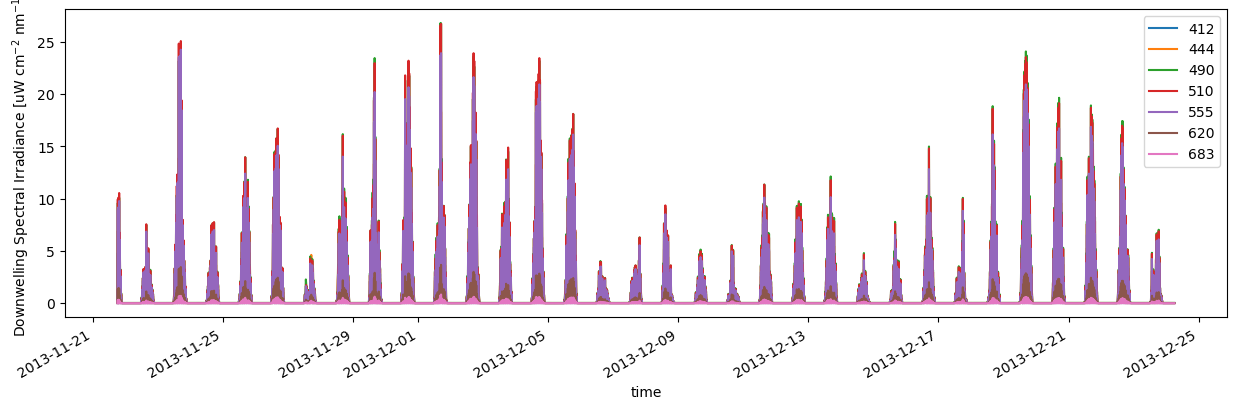

In [84]:
# Plot each channel of the downwelling irradiance data available
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

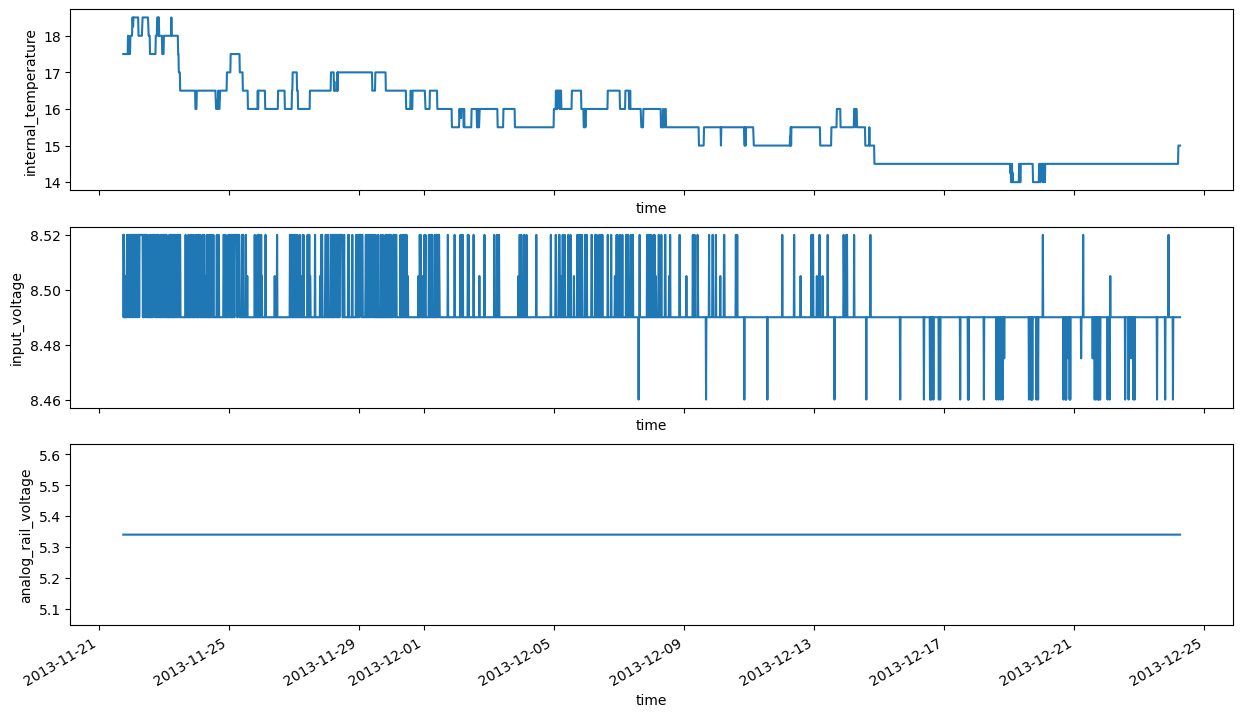

In [85]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

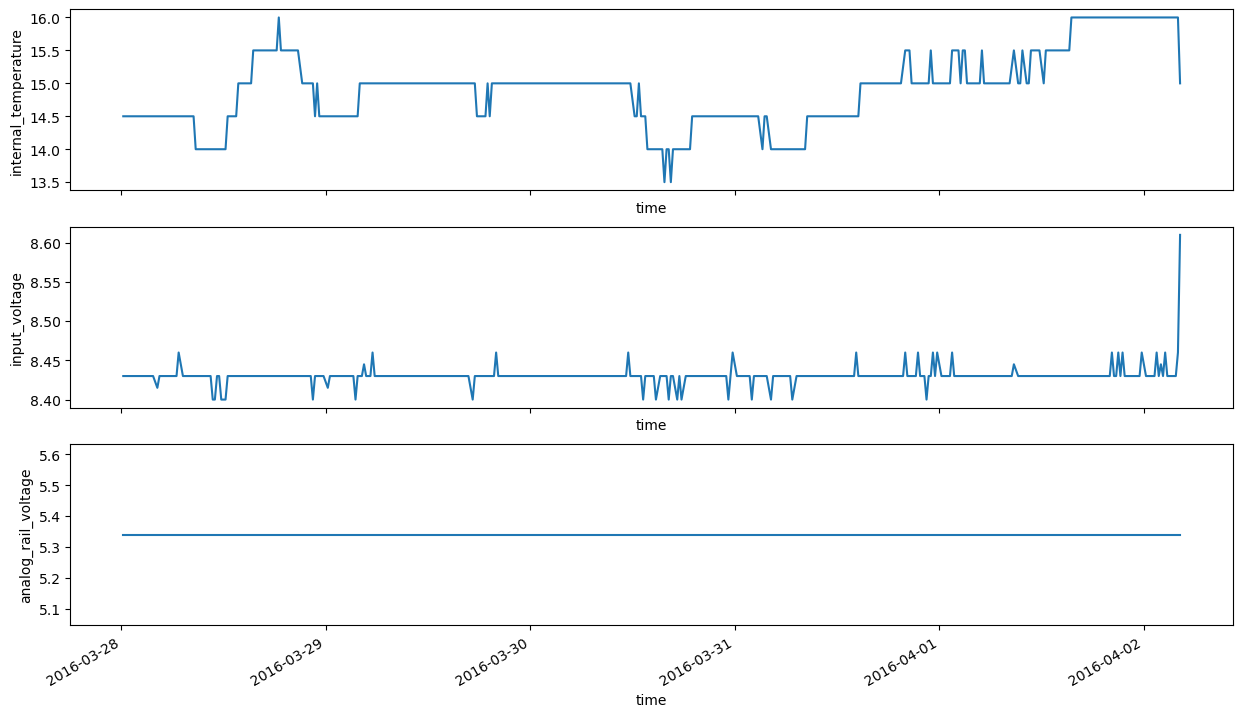

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 4
Annotation 363 for this node currently has a "not_operational" qcFlag for the data that was not telemetered. I am working on a filtering method for add_annotation_qc_flags that will only apply annotations for relevant data delivery methods. We will do this instead of adjusting the existing annotation since it affects more than one instrument. Originally, I was also thinking about annotating the few especially small irradiances scattered throughout the deployment but this seems unreasonable, and anything not within normal variability will eventually be flagged.

In [6]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 4

In [7]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


In [8]:
# Don't run code in this cell for this deployment because current QC flag for existing annotation drops most/all data
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results != 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [23]:
annotations['annotation'][0]

'Data not telemetered.'

In [9]:
spkir = nanfill_time_gaps(spkir)

In [10]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 13409, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2015-10-23T19:15:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 21.5 21.5 ... 15.0
    input_voltage                  (station, time) float32 8.46 8.46 ... 8.61
    deployment                     (station, time) float32 4.0 4.0 ... 4.0 4.0
    analog_rail_voltage            (station, time) float32 5.34 5.34 ... 5.34
    raw_irradiance_412             (station, time) float32 2.156e+09 ... 2.14...
    raw_irradiance_444             (station, time) float32 2.16e+09 ... 2.148...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.2415 ... -0.007794
    rollup_annotations_qc_results  (station, time) float32 9.0 9.0 ... 9.0 9.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.13
    lon                            (station) float32 -70.78
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

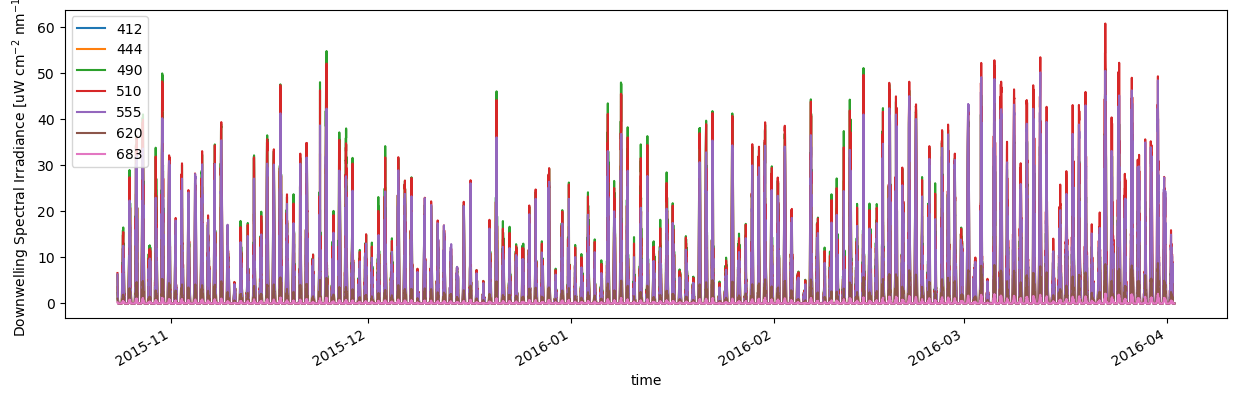

In [11]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

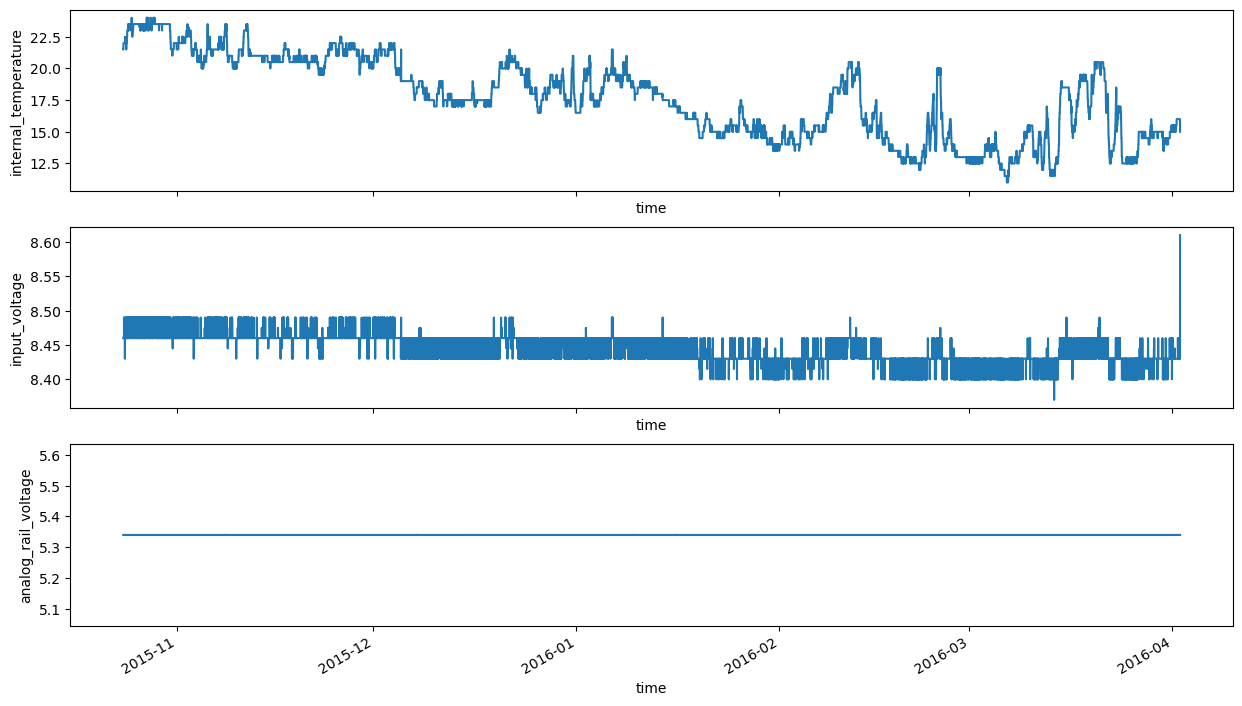

In [12]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

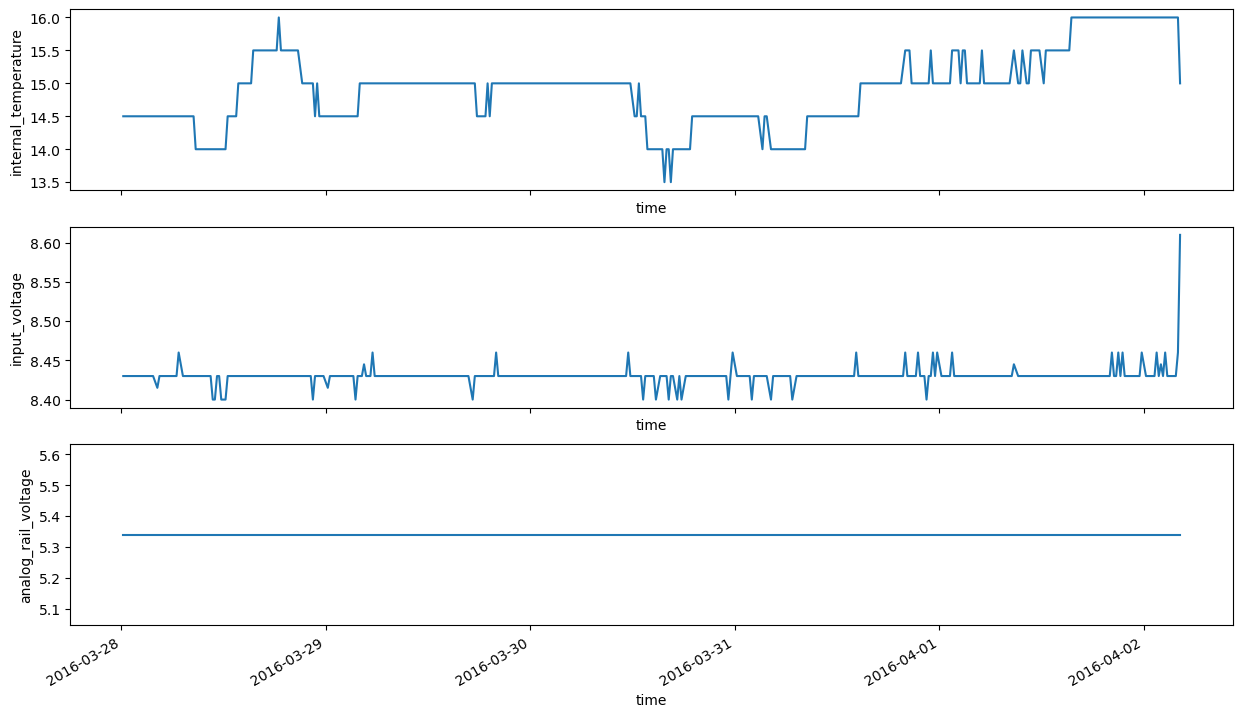

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 5
There are a few samples taken in the middle of a large gap of data. We probably won't add an annotation for these, but when we make the lookup tables we will manually ignore these. We can't say for certain whether the data is "bad" but any data that is uncharacteristic we are expecting to be flagged after running QARTOD tests on this variable.

In [25]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 5

In [26]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


In [27]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [28]:
spkir = nanfill_time_gaps(spkir)

In [29]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 12922, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2016-05-13T14:00:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 12.0 12.0 ... 25.5
    input_voltage                  (station, time) float32 8.43 8.43 ... 8.52
    deployment                     (station, time) float32 5.0 5.0 ... 5.0 5.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.34
    raw_irradiance_412             (station, time) float32 2.205e+09 ... 2.15...
    raw_irradiance_444             (station, time) float32 2.219e+09 ... 2.15...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 1.077 ... 0.3232
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.14
    lon                            (station) float32 -70.77
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

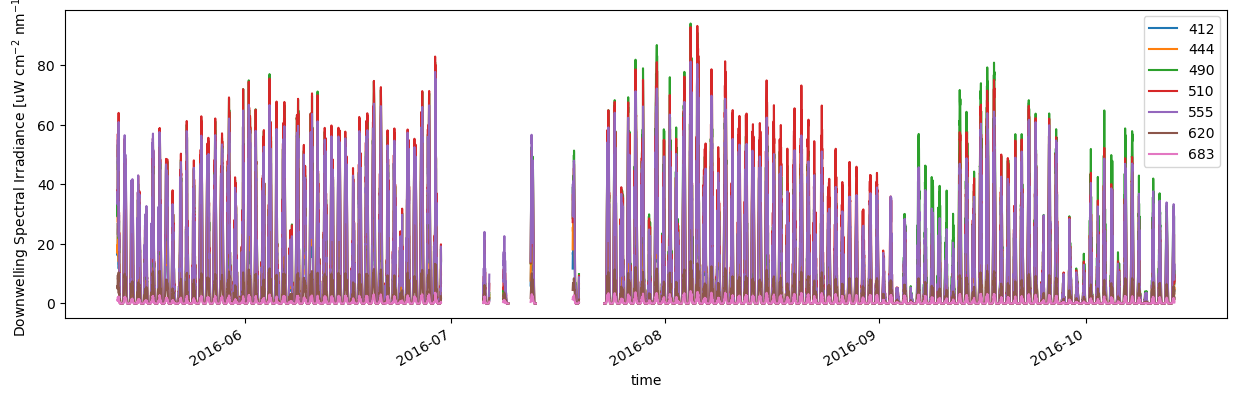

In [30]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

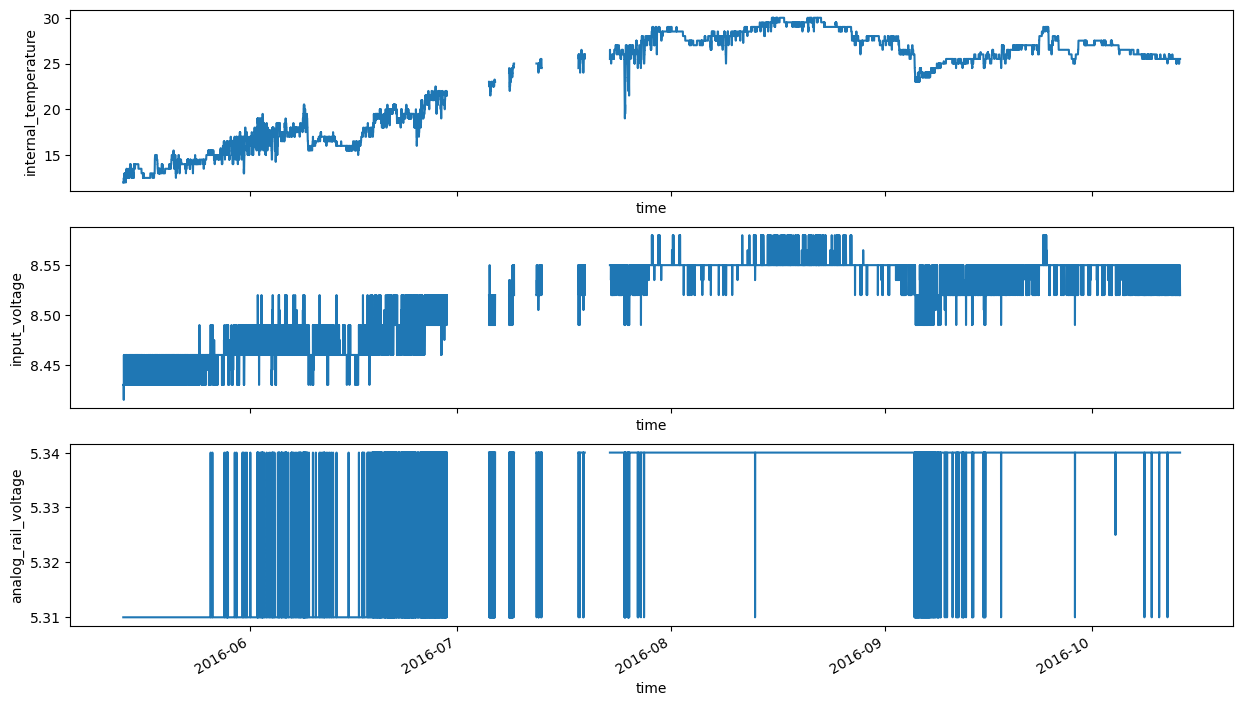

In [31]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

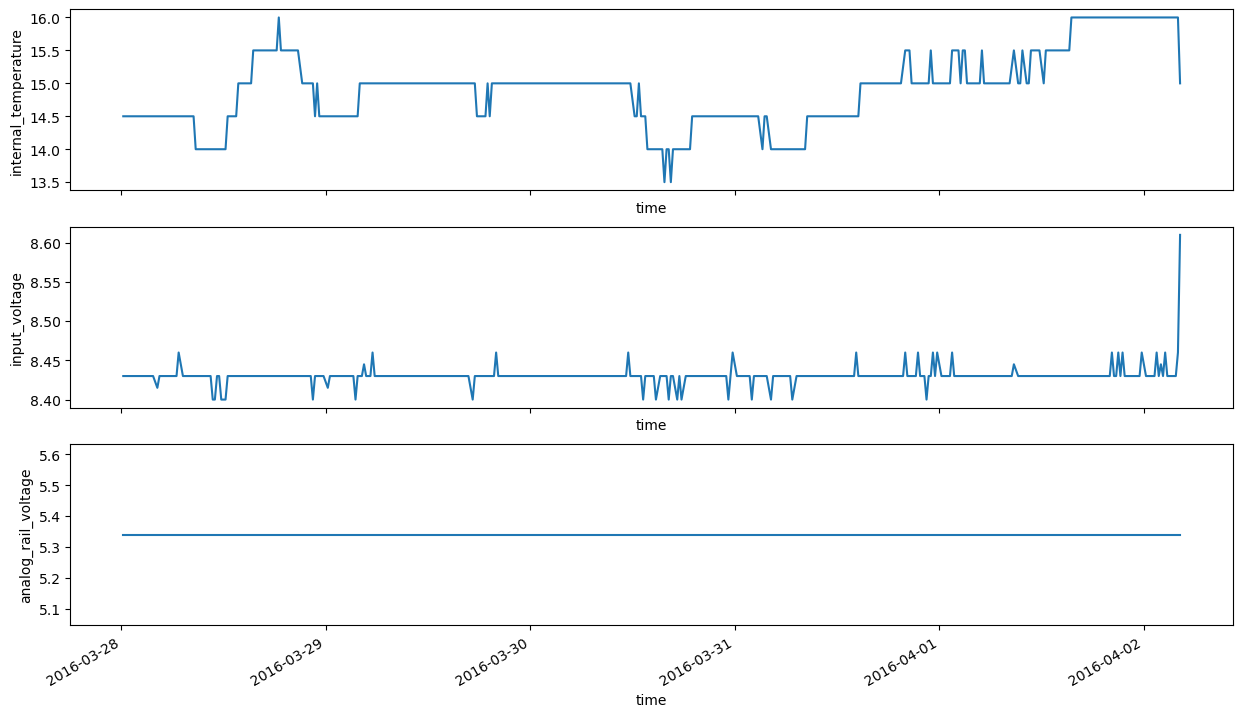

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 6
Potential biofouling. Need to compare irradiance with SWR to check whether clouds might be contributing to declining irradiance, and also compare with a co-located fluorometer to see if a co-occuring plankton bloom could be blocking downwelling irradiance from reaching the instrument face.

Also need to compare the downwelling irradiance at the end of the following deployment to see how signal has become attenuated by end of deployment.

After comparing things (last cell), it looks like the drop in spectral irradiance from Feb to Mar 2017 is not easily explained by Chl-a or cloudy conditions, but the second drop in spectral irradiance in late-Apr 2017 could have been a result of a phytoplankton bloom.

In [6]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 6

In [7]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


In [8]:
# Add QC flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [9]:
# Use initial sampling interval to fill gaps in sampling with NaNs so
# that data gaps are apparent in line plots
spkir = nanfill_time_gaps(spkir)

In [10]:
# Update attributes of the dataset and datetime format
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
# spkir

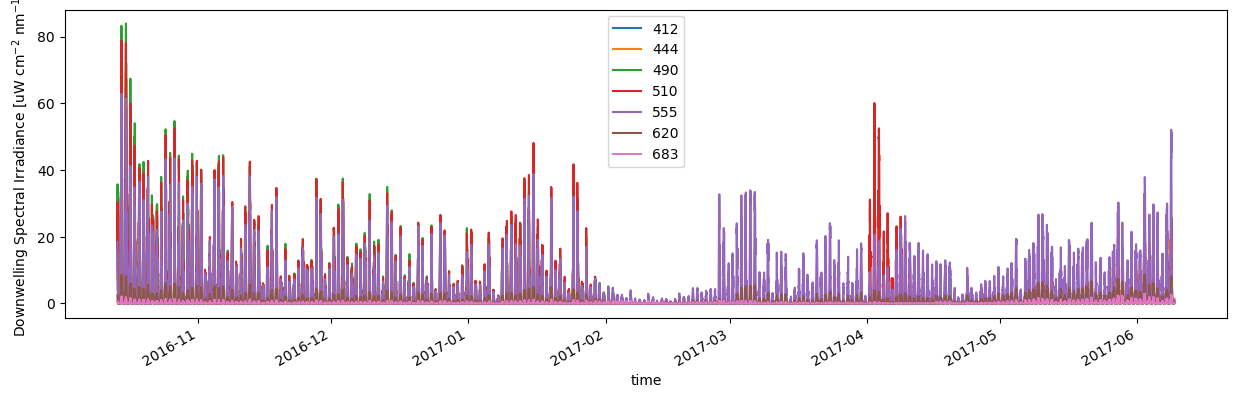

In [17]:
# Plot all 7 channels of SPKIR for full deployment
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

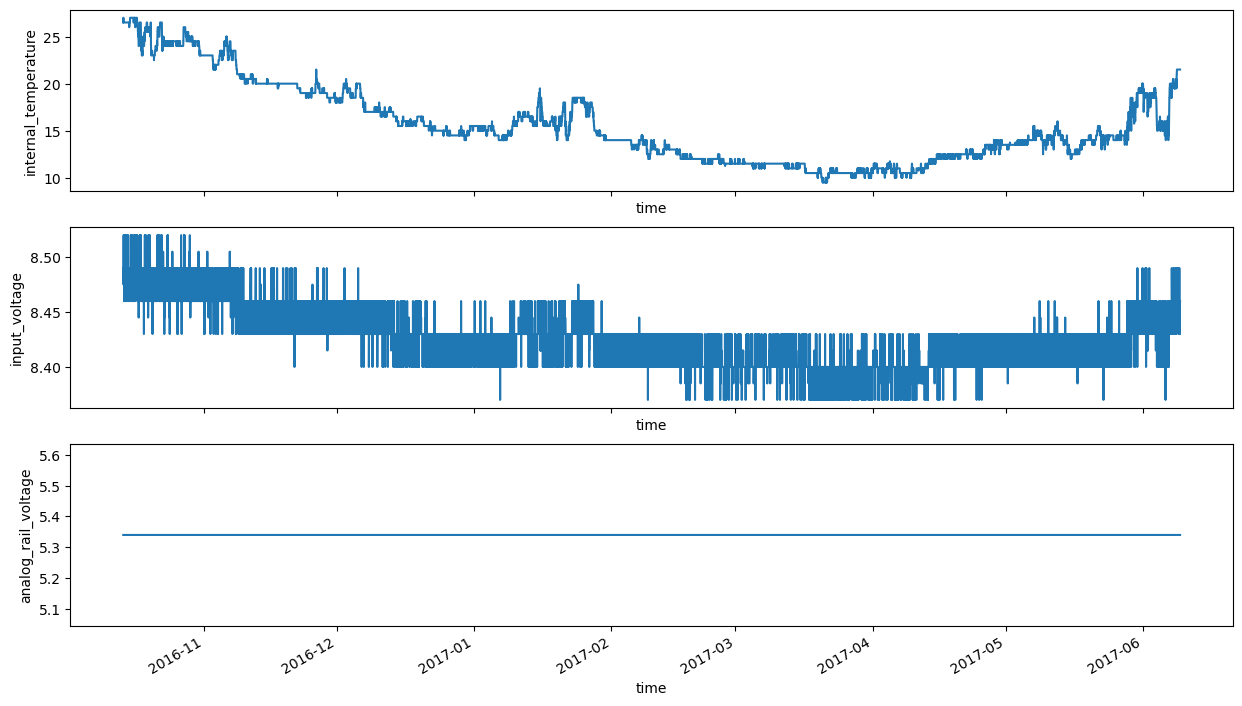

In [21]:
# Check internal temperature, supply voltage, and analog rail voltage during the full deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

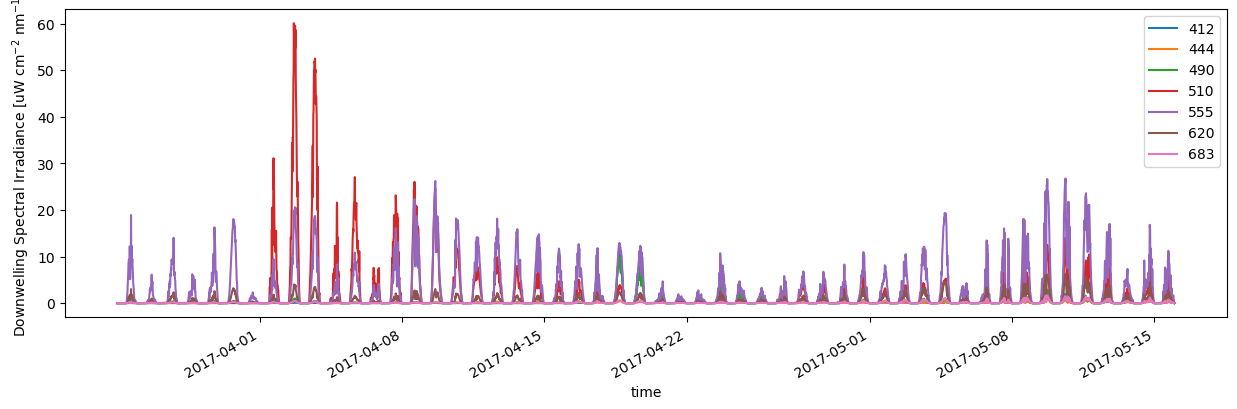

In [22]:
# Plot a shorter time series to take closer look at potential biofouling
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2017-03-25','2017-05-15')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

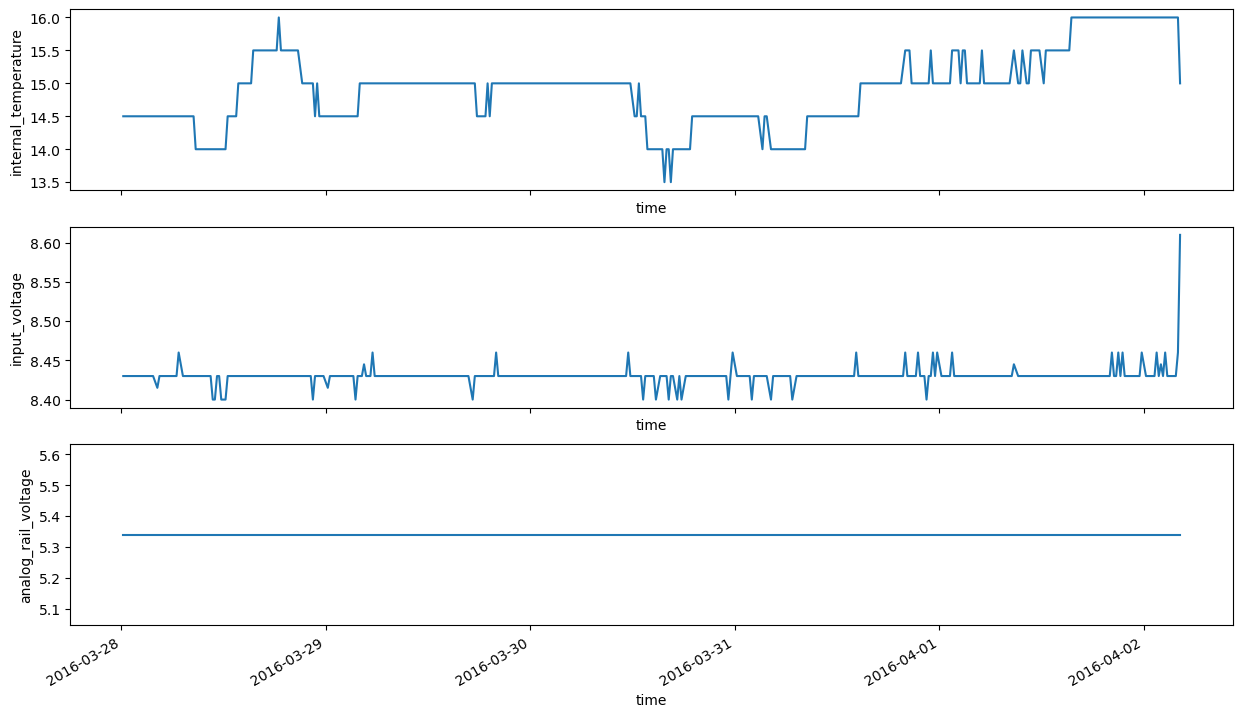

In [58]:
# Check internal temperature, supply voltage, and analog rail voltage during this shorter time period
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


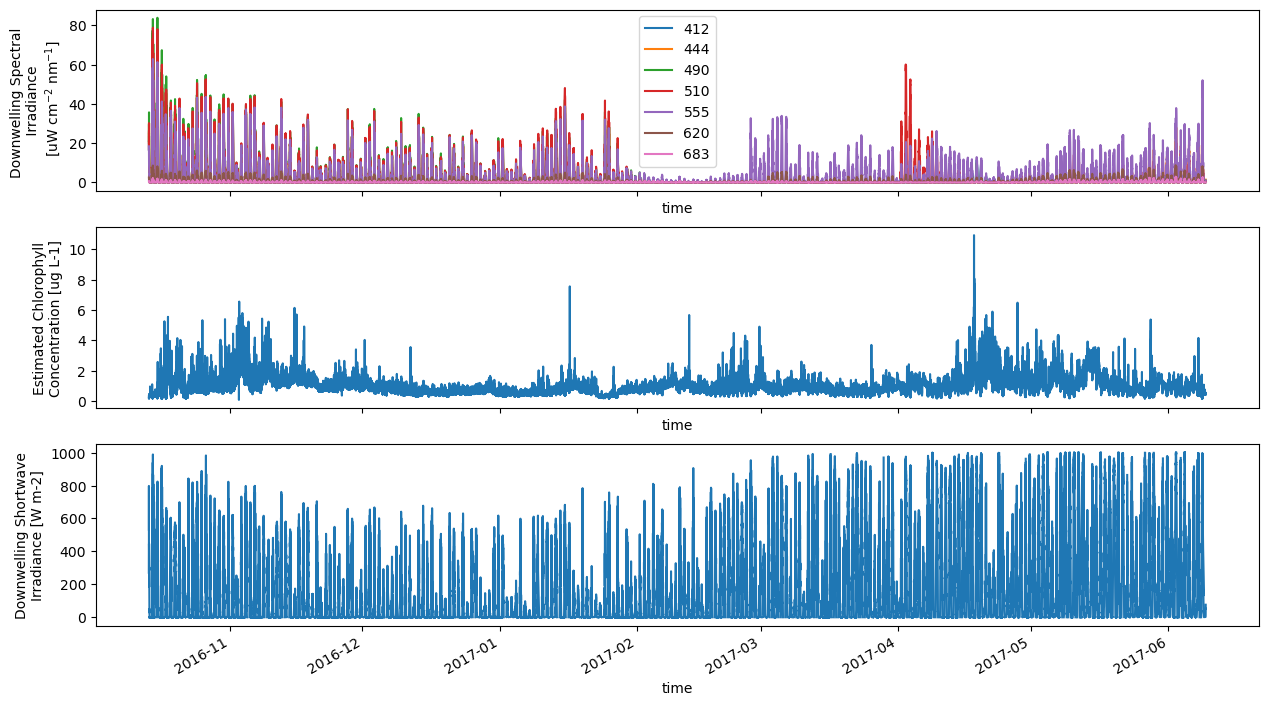

In [11]:
# Plot irradiance against SWR from the surface buoy METBK, co-located FLORT 
# site, node and sensor of the SPKIR are already defined as such
# site will be the same also for METBK and FLORT sensors. While the
# FLORT is also on the NSIF, its data goes through a different DCL such
# that the node will be different as well.
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

### Deployment 7
There is an unexplained gap that I think cannot be annotated, but there might be biofouling towards the end of the deployment.

Upon comparison of SWR and Chl-a, it looks like the initial decline in downwelling irradiance could have been caused by some cloudiness overhead, and then a phytoplankton bloom followed quickly after SWR rebounded, potentially blocking more downwelling irradiance for an extended time. There were a few more spikes in Chl-a after this and SWR from the METBK suite seems to trend negatively at the same time. It's hard to say for sure, but this might not be biofouling as the trend in spectral irradiance is similar to the downwelling shortwave irradiance above the surface. 

It looks like the spectral irradiance continues to drop slightly as observed by the fresh SPKIR at the start of deployment 8, and it remains fairly low in magnitude through the winter months. I still think that this is not necessarily biofouling.

In [37]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 7

In [38]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


In [39]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [40]:
spkir = nanfill_time_gaps(spkir)

In [41]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 12527, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2017-06-09T14:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 18.0 17.5 ... 23.0
    input_voltage                  (station, time) float32 8.49 8.49 ... 8.49
    deployment                     (station, time) float32 7.0 7.0 ... 7.0 7.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.31
    raw_irradiance_412             (station, time) float32 2.276e+09 ... 2.15...
    raw_irradiance_444             (station, time) float32 2.337e+09 ... 2.15...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 2.454 ... 0.05656
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.14
    lon                            (station) float32 -70.77
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

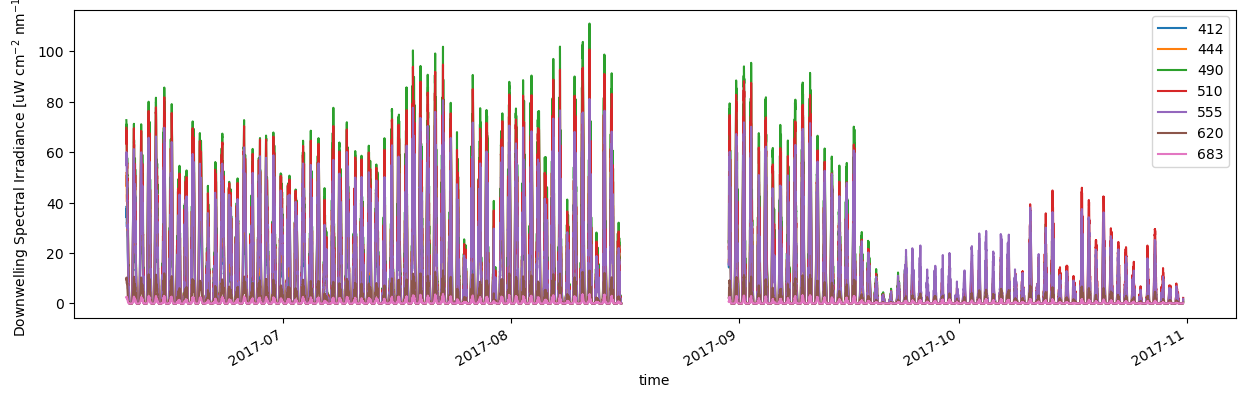

In [44]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

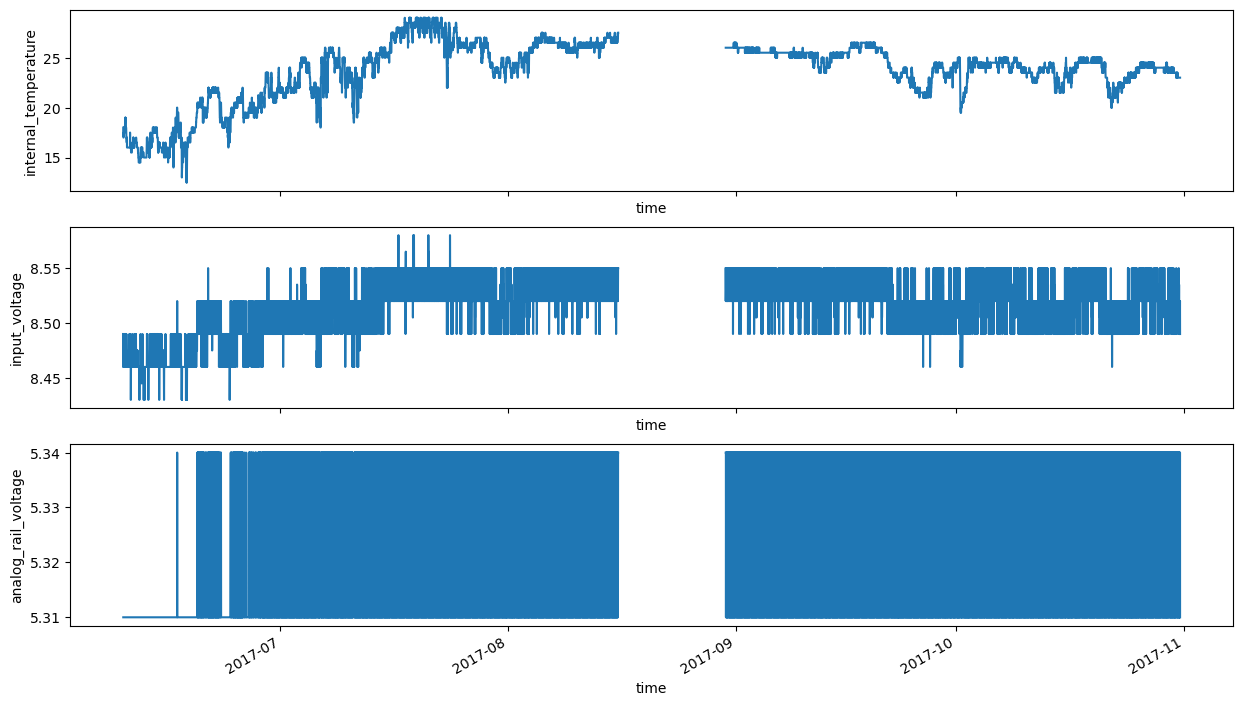

In [45]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


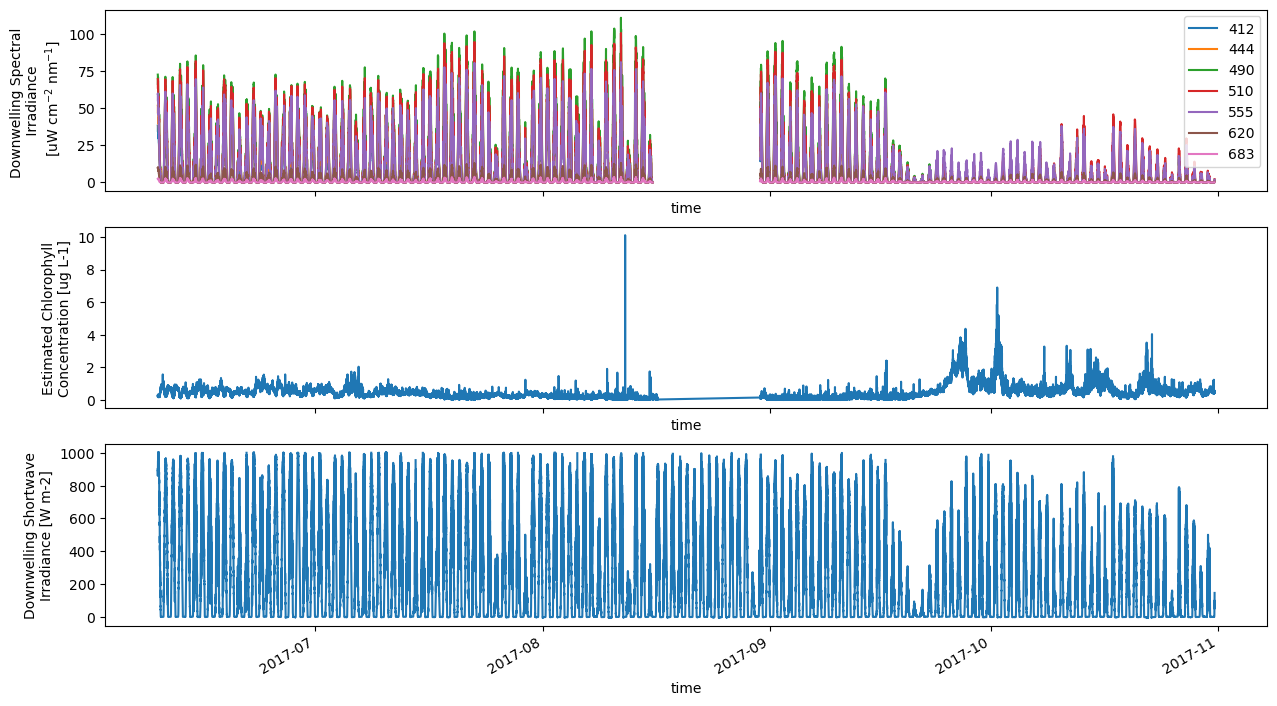

In [17]:
# Look at trends in SWR and Chl-a toward end of deployment to look for
# other causes for the decline in downwelling spectral irradiance
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]


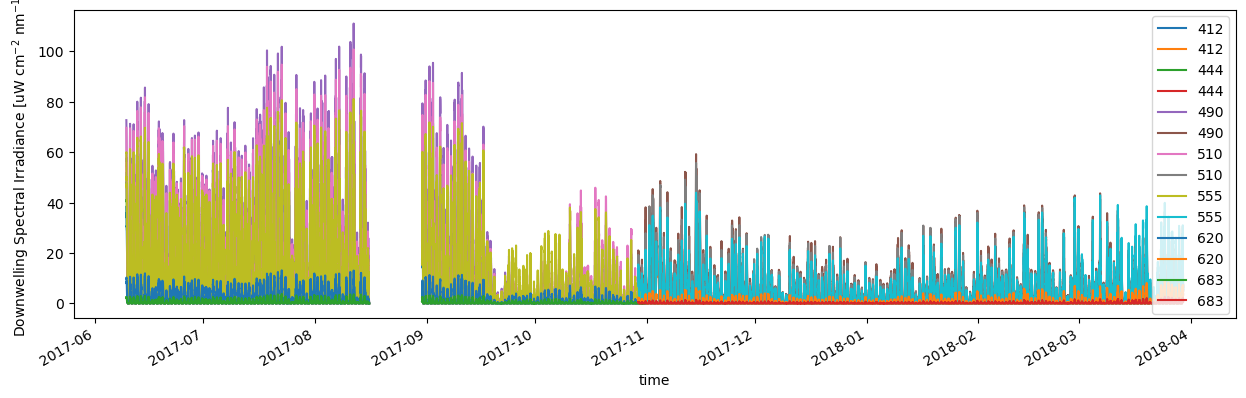

In [42]:
# Plot deployment 10 and 11 consecutively to check change between deployments
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir_08 = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % 8))
spkir_08 = spkir_datalogger(spkir_08, burst=True)

# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir_08 = add_annotation_qc_flags(spkir_08, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir_08 = spkir_08.where(spkir_08.rollup_annotations_qc_results < 4) # flags from annotations

# Update dataset attributes and time format
spkir_08 = nanfill_time_gaps(spkir_08)
vocab = get_vocabulary(site, node, sensor)[0]
spkir_08 = update_dataset(spkir_08, vocab['maxdepth'])
spkir_08['time'] = pd.to_datetime(spkir_08.time, unit='s')

# Plot deployments 10 and 11 on same axes
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
        spkir_08[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

### Deployment 10
There might be biofouling in the last 2 weeks of the deployment.

The Chl-a estimate increases a little towards the end of the deployment, but the decline in spectral irradiance is much larger at that time than earlier in the deployment when the increase in Chl-a was estimated to be much higher. The observed shortwave irradiance at 5 m elevation at the end of that deployment also does not show a clear trend positive or negative, so I would have expected no change.
Comparison of end of deployment 10 with start of deployment 11 shows that the observations at the end of deployment 10 are not consistent with the observations from the fresh deployment 11 SPKIR. 
None of this rejects the possibility that biofouling is responsible for the decline in spectral irradiance at the end of deployment 10.

In [30]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 10

In [31]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


In [32]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [33]:
spkir = nanfill_time_gaps(spkir)

In [34]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 15311, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2018-10-30T01:45:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 nan 15.5 ... 8.0 8.0
    input_voltage                  (station, time) float32 nan 8.43 ... 8.37
    deployment                     (station, time) float32 nan 10.0 ... 10.0
    analog_rail_voltage            (station, time) float32 nan 5.34 ... 5.34
    raw_irradiance_412             (station, time) float32 nan ... 2.153e+09
    raw_irradiance_444             (station, time) float32 nan ... 2.15e+09
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 nan ... 0.1809
    rollup_annotations_qc_results  (station, time) float32 nan 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.13
    lon                            (station) float32 -70.78
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

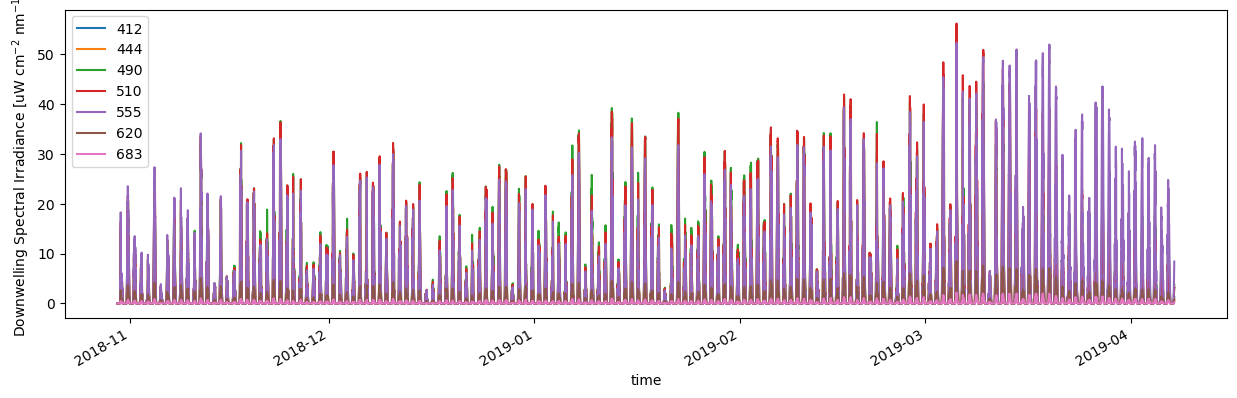

In [51]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

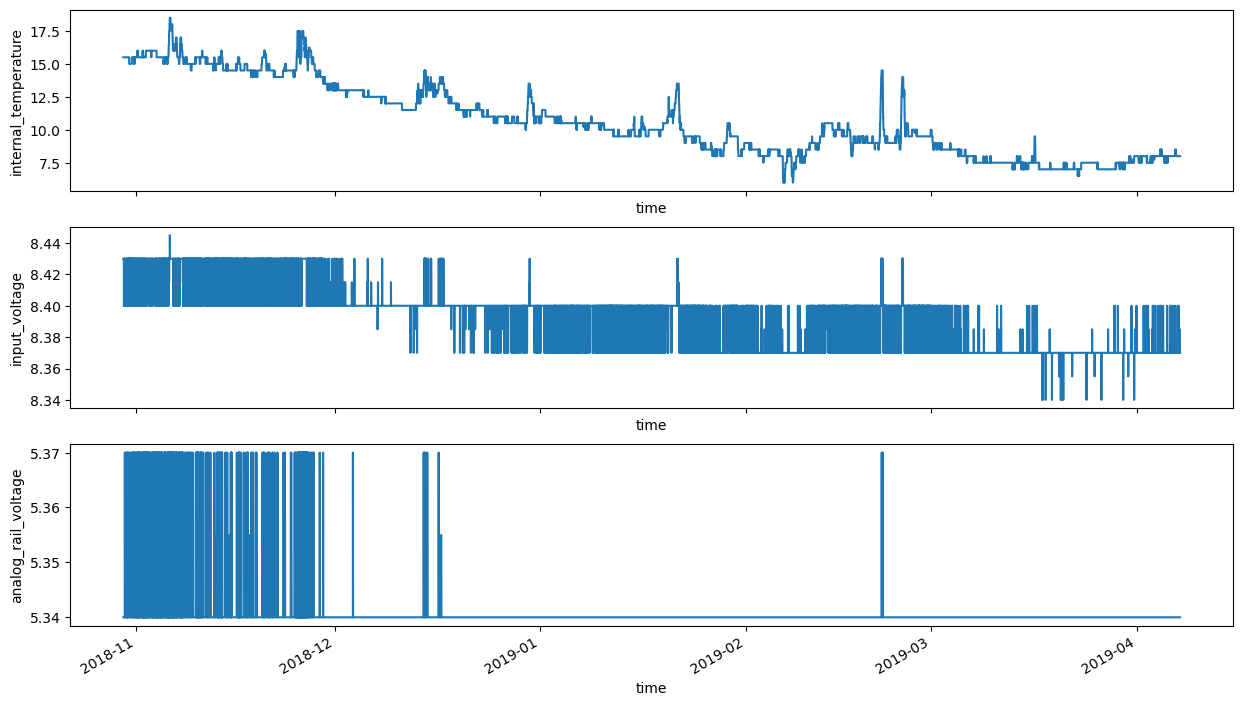

In [52]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


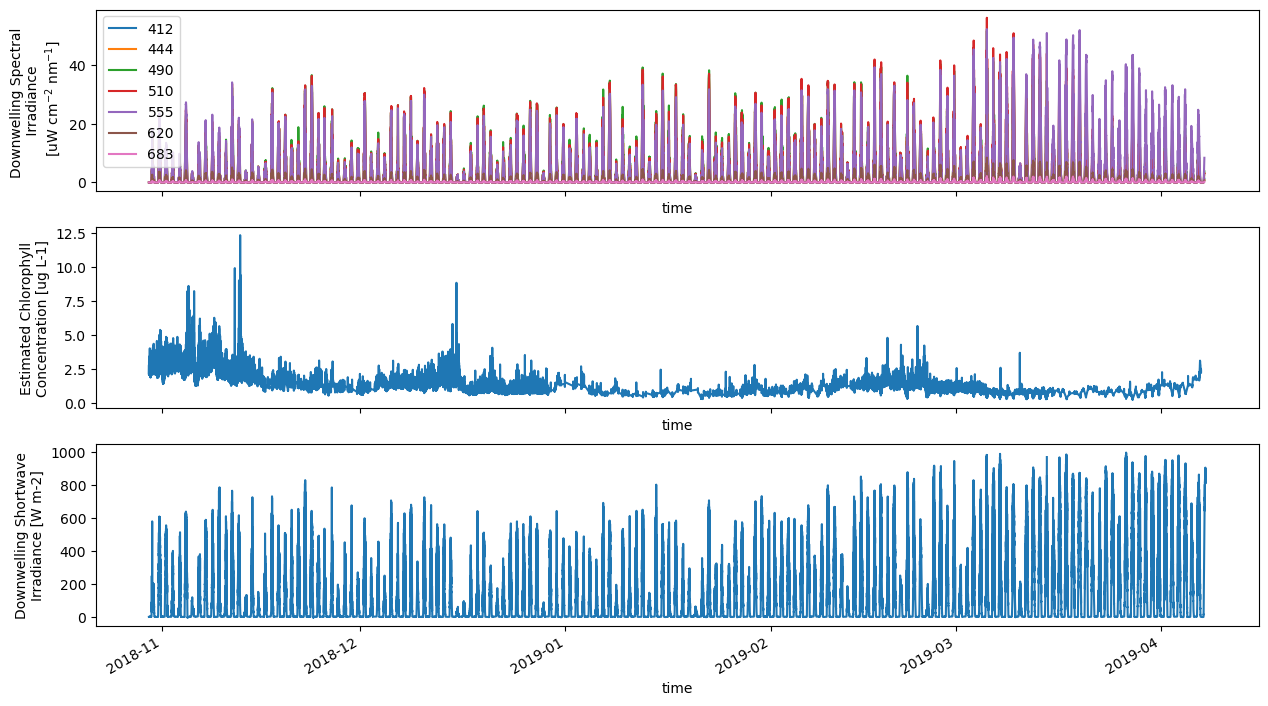

In [35]:
# Compare spectral irradiance over the deployment to downwelling
# shortwave irradiance (at 5 m elevation) and Chl-a estimated from
# 3-wavelength fluorometer
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]


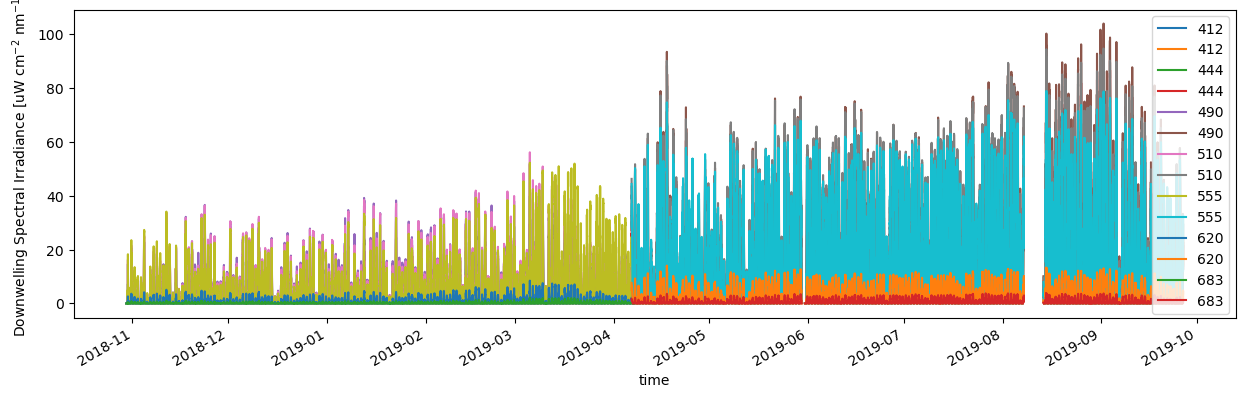

In [36]:
# Plot deployment 10 and 11 consecutively to check change between deployments
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir_11 = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % 11))
spkir_11 = spkir_datalogger(spkir_11, burst=True)

# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir_11 = add_annotation_qc_flags(spkir_11, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir_11 = spkir_11.where(spkir_11.rollup_annotations_qc_results < 4) # flags from annotations

# Update dataset attributes and time format
spkir_11 = nanfill_time_gaps(spkir_11)
vocab = get_vocabulary(site, node, sensor)[0]
spkir_11 = update_dataset(spkir_11, vocab['maxdepth'])
spkir_11['time'] = pd.to_datetime(spkir_11.time, unit='s')

# Plot deployments 10 and 11 on same axes
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
        spkir_11[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

### Deployment 11
Unexplained gap in data that can't be annotated.

In [53]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 11

In [54]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


In [55]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [56]:
spkir = nanfill_time_gaps(spkir)

In [57]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 15982, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2019-04-06T14:45:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 10.5 10.5 ... 28.0
    input_voltage                  (station, time) float32 8.31 8.34 ... 8.4
    deployment                     (station, time) float32 11.0 11.0 ... 11.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.31
    raw_irradiance_412             (station, time) float32 2.216e+09 ... 2.19...
    raw_irradiance_444             (station, time) float32 2.255e+09 ... 2.19...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 1.671 ... 0.4609
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.14
    lon                            (station) float32 -70.77
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

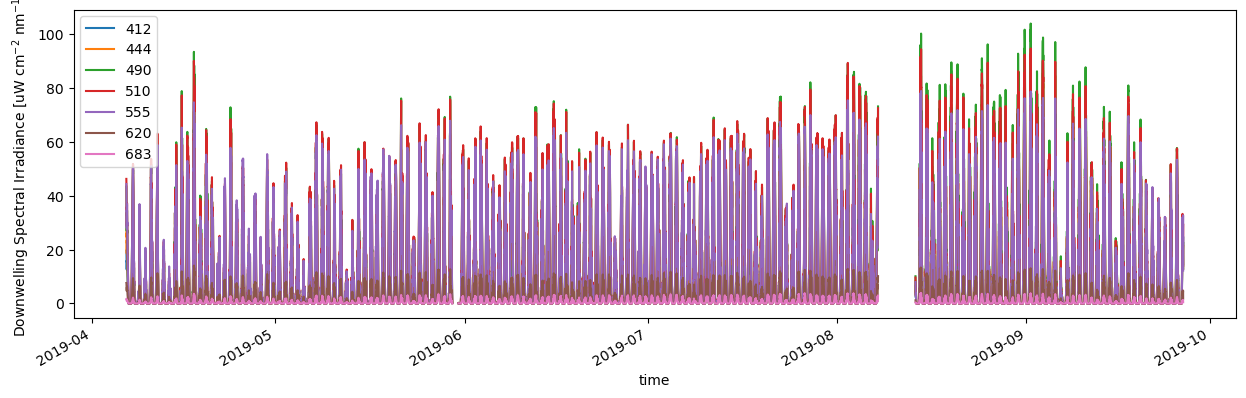

In [58]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

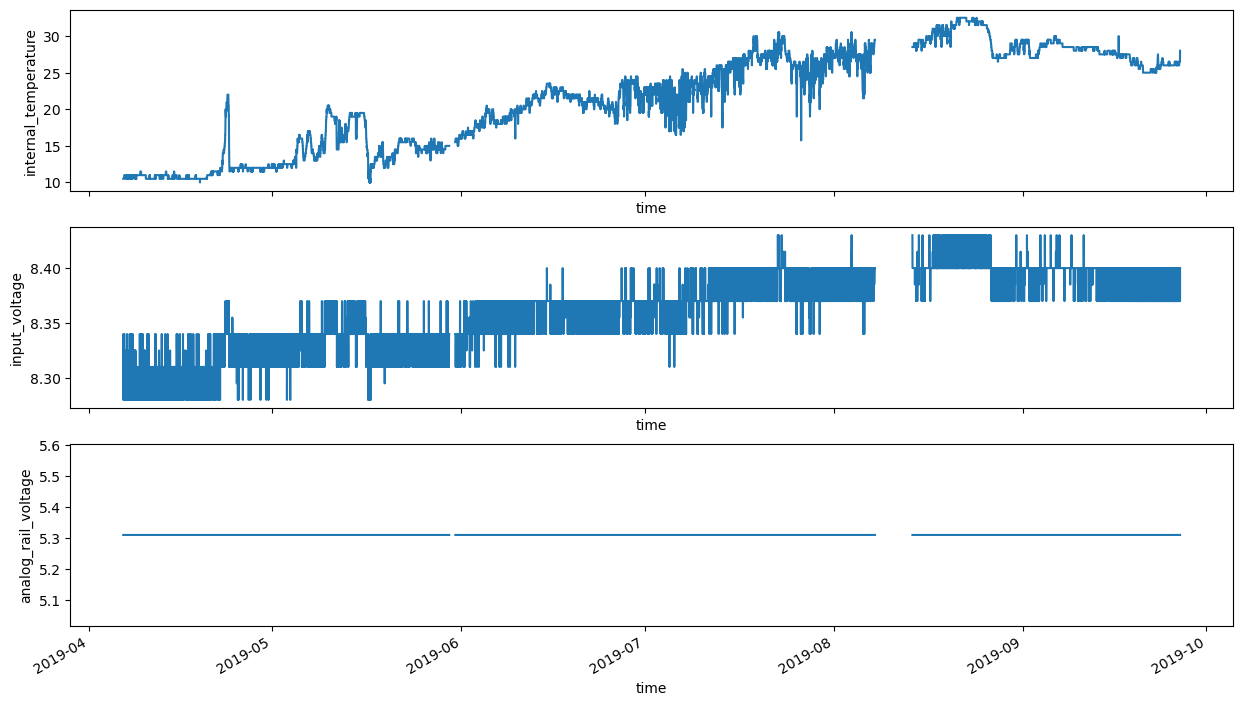

In [59]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

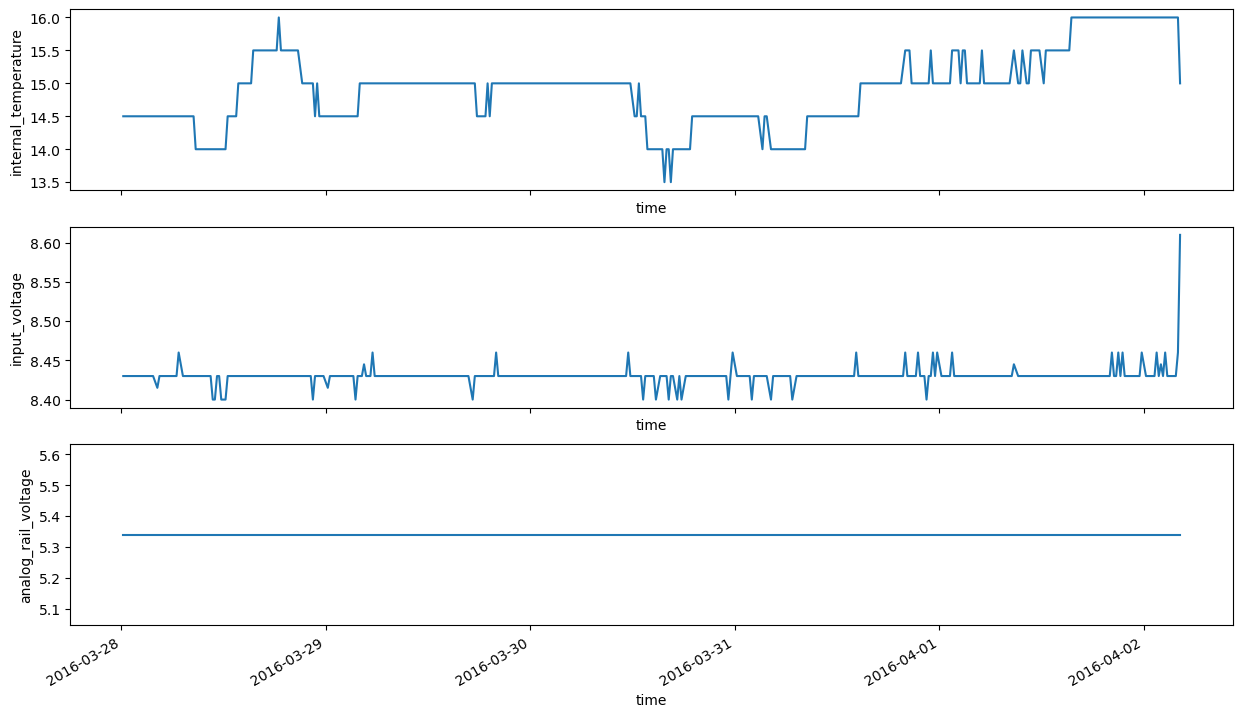

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 16
Add annotation with suspect flag for biofouling for data that looks like it was likely affected by the UV light failing. 

The decline in spectral irradiance after the first week of Aug 2022 is sudden and doesn't appear to co-occur with a large, sustained bloom. There also isn't a large decline in shortwave irradiance to suggest increased cloudiness at the same time. I suspect that the data from the lowest point of the initial decline of irradiance through the end of the deployment is impacted by biofouling. 

I don't know what to make of the FLORT and shortwave irradiance wackiness. I don't know if I knew previously whether this deployment was any longer.

<ul>
    <li>We can't check difference in irradiance between end of deployment 16 and another deployment since it is the last, but maybe we can compare the irradiance with irradiance that is less suspect at a similiar time of year</li>
</ul>

In [18]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 16

In [19]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


In [20]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [21]:
spkir = nanfill_time_gaps(spkir)

In [22]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 14879, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2022-04-13T11:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 14.0 14.0 ... nan nan
    input_voltage                  (station, time) float32 8.4 8.4 ... nan nan
    deployment                     (station, time) float32 16.0 16.0 ... nan nan
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... nan nan
    raw_irradiance_412             (station, time) float32 2.155e+09 ... nan
    raw_irradiance_444             (station, time) float32 2.158e+09 ... nan
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.1203 0.1775 ... nan
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... nan nan
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.13
    lon                            (station) float32 -70.78
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

In [23]:
# Print message for annotation about UV light failing
annotations['annotation'][9]

'Deployment 16: The UV light failured during the deployment.  The instrument face was found to be biofouled on recovery.'

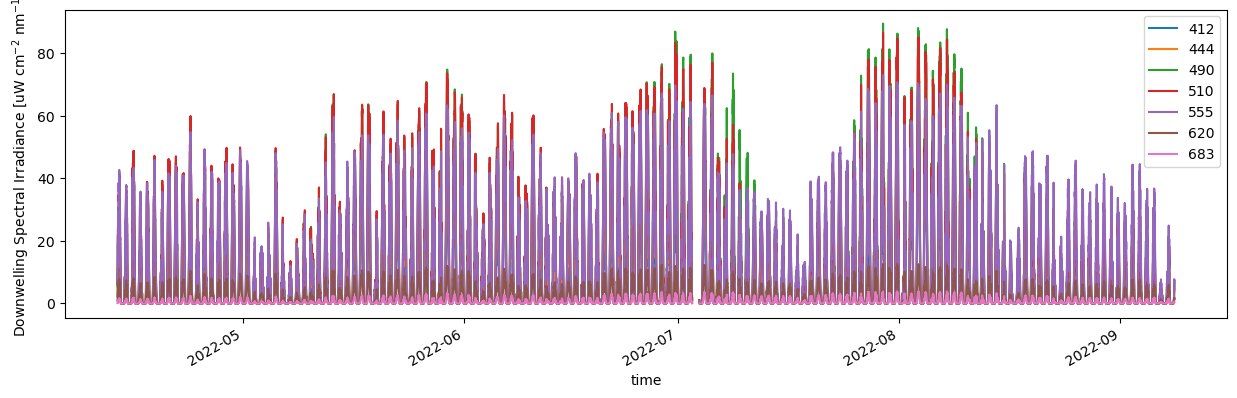

In [65]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

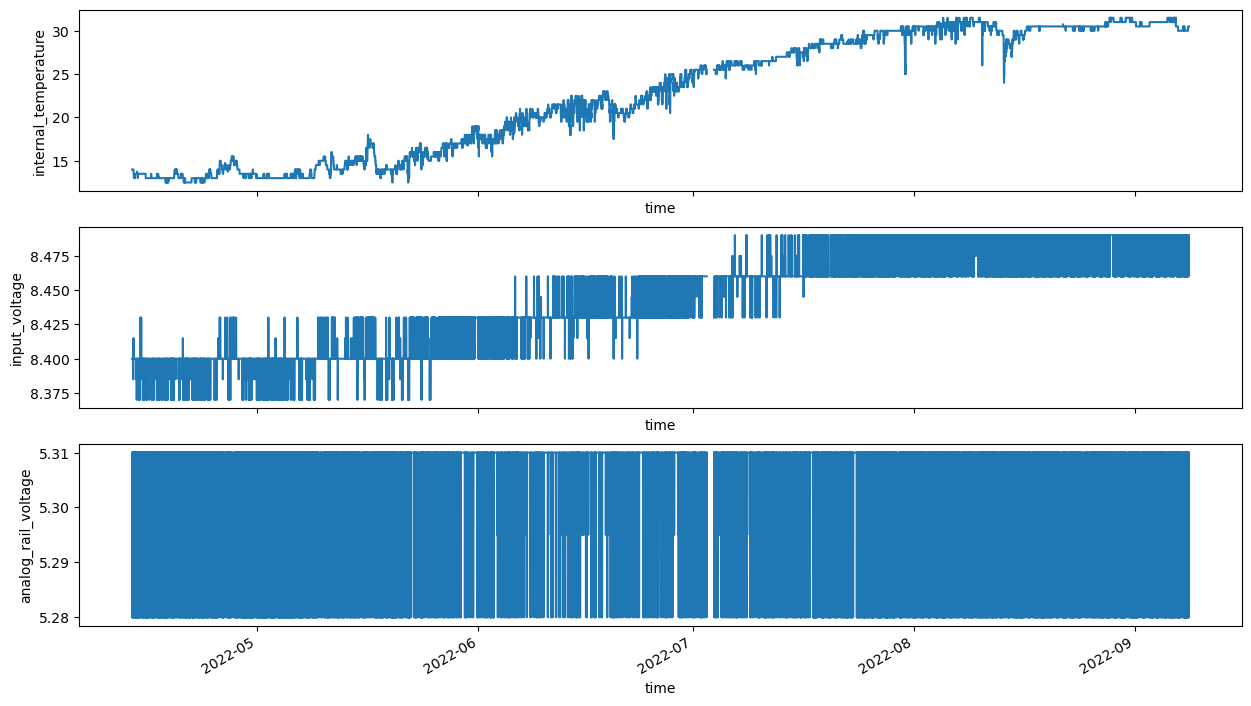

In [66]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


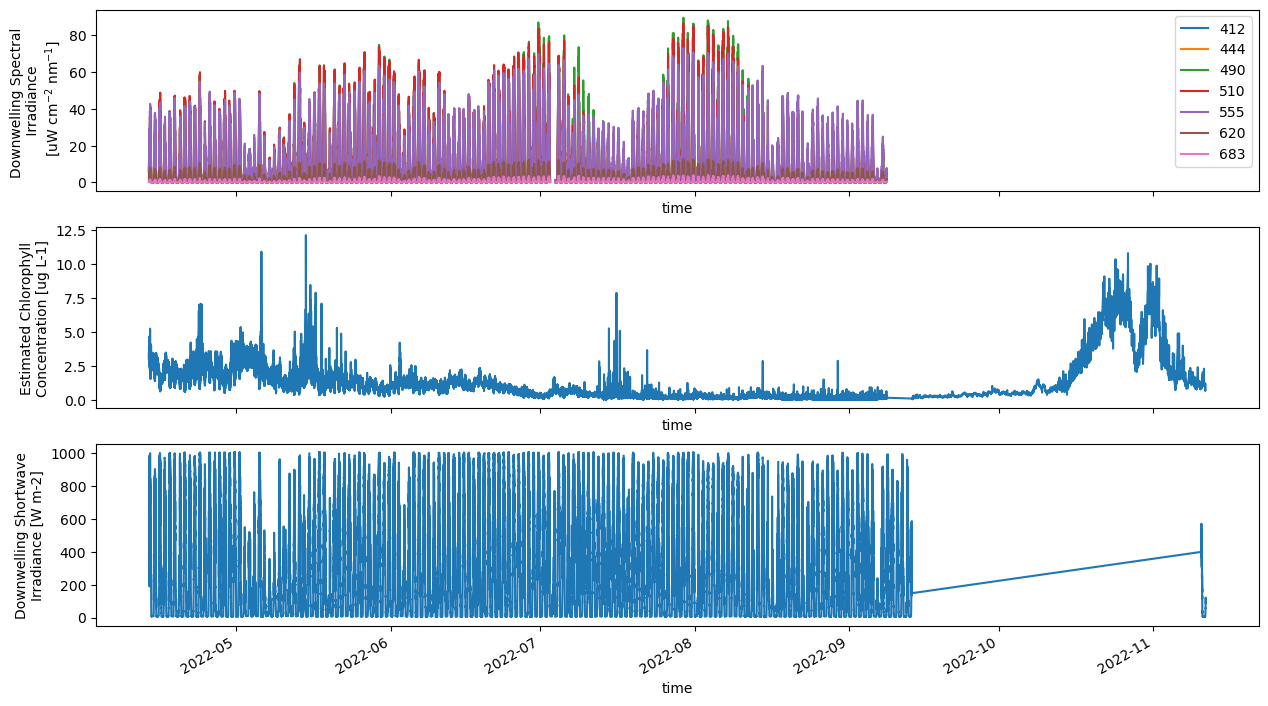

In [24]:
# Check behavior of shortwave irradiance and Chl-a during deployment
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

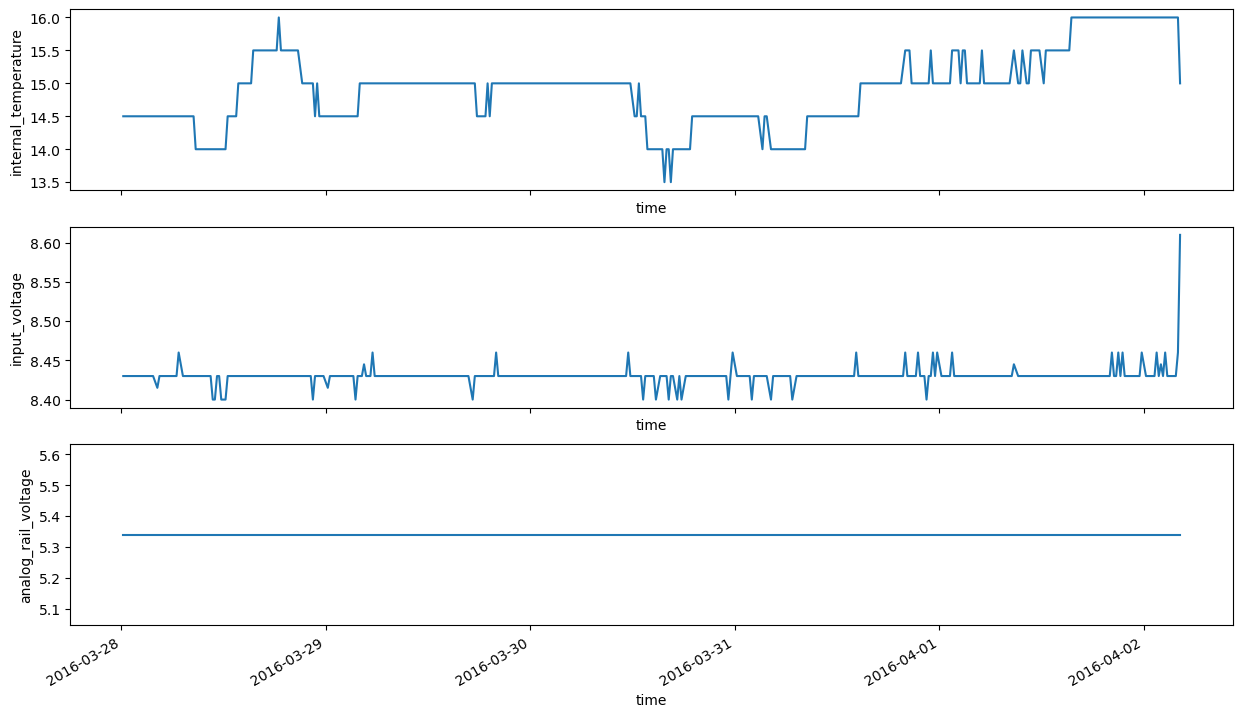

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Histograms of downwelling irradiance measurements

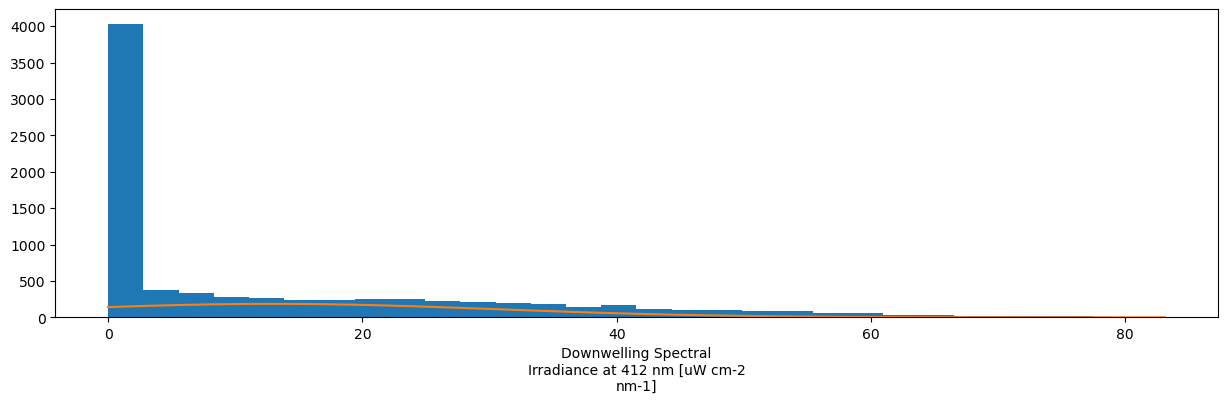

In [30]:
# histogram of downwelling irradiance @ 412 nm variable
irrad412 = spkir['downwelling_irradiance_412'][0]
# irrad412 = spkir['downwelling_irradiance_412'][0].sel(time=slice('2017-07-01'))
mu412 = irrad412.mean()
sig412 = irrad412.std()

plt.figure(figsize=(15,4))
c, x, h = irrad412.plot.hist(bins=30)
norm412 = sum(c)*norm.pdf(x, mu412, sig412)
plt.plot(x, norm412)

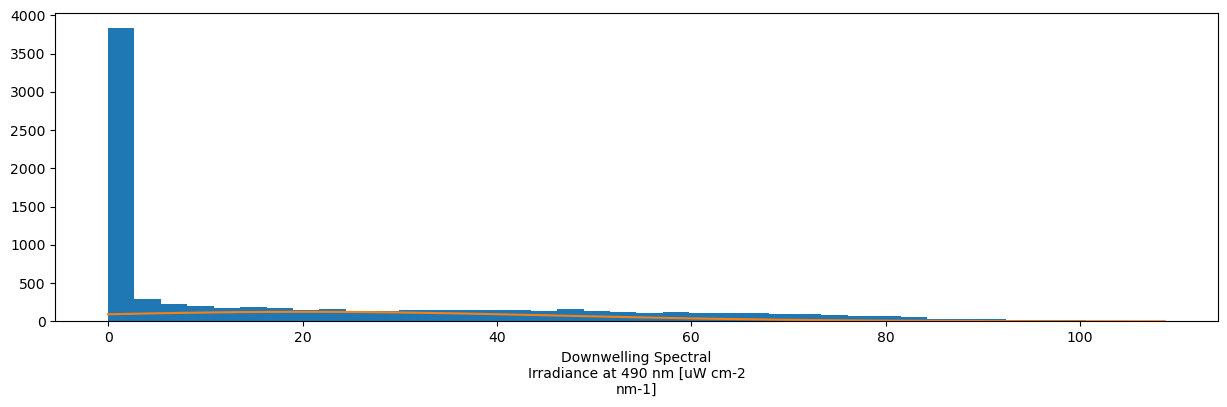

In [31]:
# histogram of downwelling irradiance @ 490 nm variable
irrad490 = spkir['downwelling_irradiance_490'][0]
# irrad490 = spkir['downwelling_irradiance_490'][0].sel(time=slice('2017-07-01'))
mu490 = irrad490.mean()
sig490 = irrad490.std()

plt.figure(figsize=(15,4))
c, x, h = irrad490.plot.hist(bins=40)
norm490 = sum(c)*norm.pdf(x, mu490, sig490)
plt.plot(x, norm490)

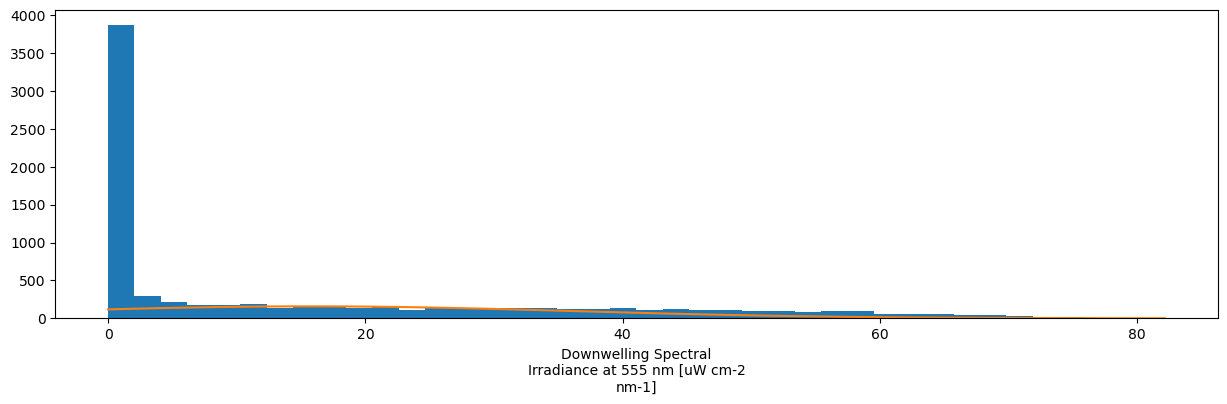

In [32]:
# histogram of downwelling irradiance @ 555 nm variable
irrad555 = spkir['downwelling_irradiance_555'][0]
# irrad555 = spkir['downwelling_irradiance_555'][0].sel(time=slice('2015-06-01'))
mu555 = irrad555.mean()
sig555 = irrad555.std()

plt.figure(figsize=(15,4))
c, x, h = irrad555.plot.hist(bins=40)
norm555 = sum(c)*norm.pdf(x, mu555, sig555)
plt.plot(x, norm555)

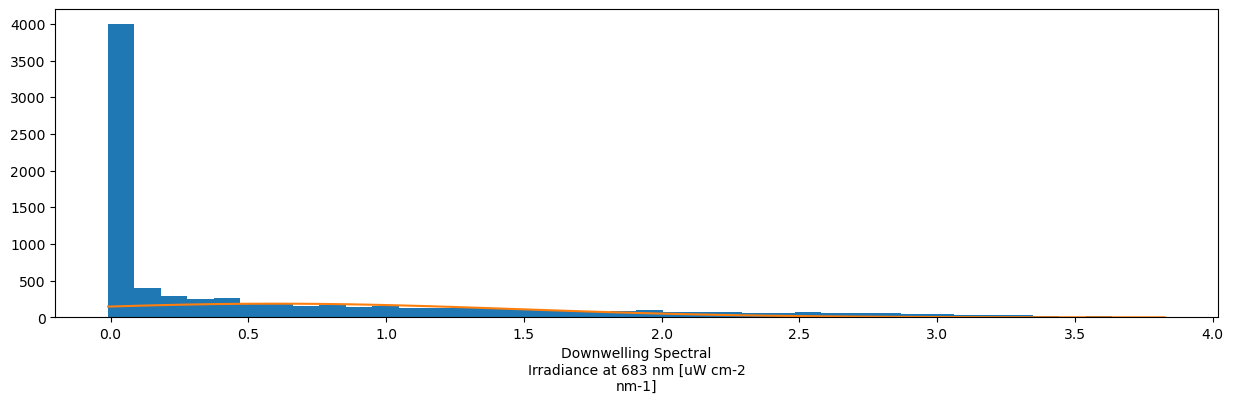

In [33]:
# histogram of downwelling irradiance @ 683 nm variable
irrad683 = spkir['downwelling_irradiance_683'][0]
# irrad683 = spkir['downwelling_irradiance_683'][0].sel(time=slice('2017-07-01'))
mu683 = irrad683.mean()
sig683 = irrad683.std()

plt.figure(figsize=(15,4))
c, x, h = irrad683.plot.hist(bins=40)
norm683 = 0.05*sum(c)*norm.pdf(x, mu683, sig683)
plt.plot(x, norm683)

In [34]:
# concat the different irradiance variables for histogram of all irradiance values
irradAll = xr.DataArray()
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        irradAll = xr.concat([irradAll, spkir[var][0]], dim='channel')
irradAll

<xarray.DataArray (channel: 8, time: 8581)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-1.24489265e-02, -1.22679379e-02, -1.27385072e-02, ...,
         3.33838081e+01,  2.91790657e+01,  2.71376114e+01],
       [-2.28602290e-02, -2.30053701e-02, -2.28148736e-02, ...,
         4.15520287e+01,  3.64205742e+01,  3.37744560e+01],
       ...,
       [-8.62311665e-03, -7.81955104e-03, -8.97590257e-03, ...,
         3.88252945e+01,  3.34404564e+01,  3.07892475e+01],
       [ 1.19705470e-02,  1.19244633e-02,  1.15373600e-02, ...,
         4.89614058e+00,  4.12962008e+00,  3.72692156e+00],
       [-4.96644620e-03, -5.32475766e-03, -4.51855734e-03, ...,
         1.25258076e+00,  1.05488253e+00,  9.43447709e-01]])
Coordinates:
  * time     (time) datetime64[ns] 2015-05-09T01:00:00 ... 2015-09-28T19:45:00
Dimensions without coordinates: channel

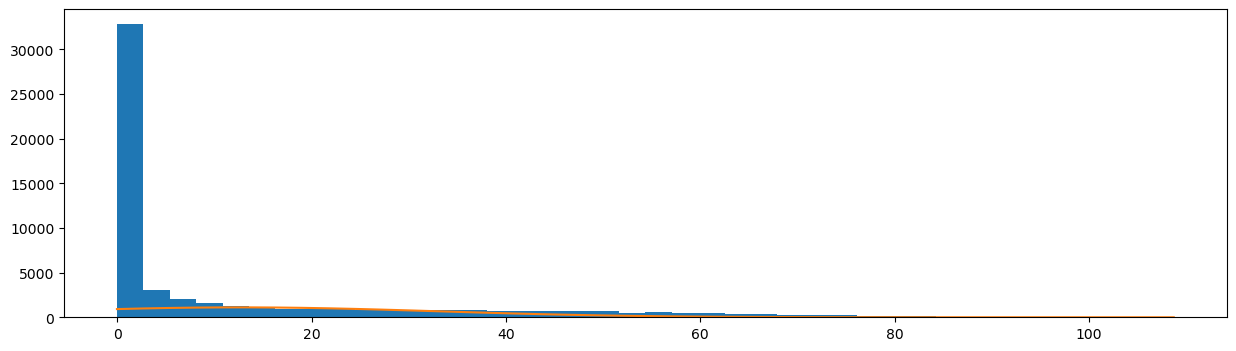

In [35]:
# histogram using all irradiance values
radAll= irradAll
muAll = radAll.mean()
sigAll = radAll.std()

plt.figure(figsize=(15,4))
c, x, h = radAll.plot.hist(bins=40)
normAll = sum(c)*norm.pdf(x, muAll, sigAll)
plt.plot(x, normAll)

### Histograms after monthly mean filter

### Spectrograms of downwelling irradiance (not burst averaged)

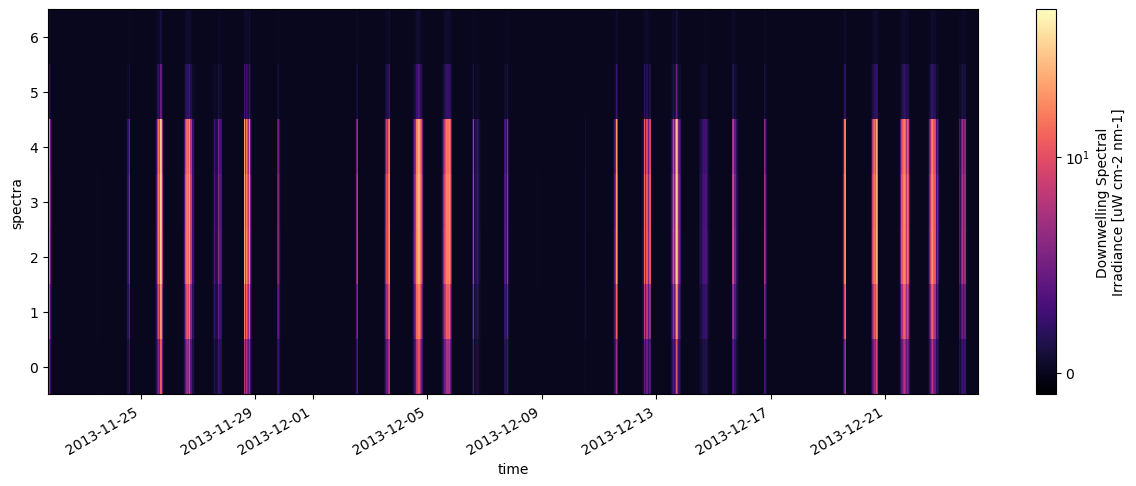

In [20]:
# Trying same plot with full resolution data with log-scale colormap (linear between -1,10)
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [28]:
# That was a bad idea so let's resample to daily
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="1D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 174, spectra: 7)>
array([[ 9.71255556e+00,  1.33028855e+01,  1.93817753e+01, ...,
         2.23164523e+01,  3.62021577e+00,  7.82912088e-01],
       [ 6.20054185e-01,  9.06080839e-01,  1.34600973e+00, ...,
         1.25914219e+00,  1.82409459e-01,  5.95385999e-02],
       [ 1.73746901e-01,  2.63608506e-01,  3.78101900e-01, ...,
         4.27118953e-01,  6.74665225e-02,  3.25888514e-02],
       ...,
       [ 7.39844170e-02,  7.86333704e-02,  8.35438973e-02, ...,
         5.61443408e-02,  8.31668786e-03,  4.77597635e-03],
       [ 2.28589437e-01,  2.76852485e-01,  3.28657073e-01, ...,
         2.09412793e-01,  2.62619446e-02,  1.17360818e-02],
       [ 2.29803754e-03,  3.92295552e-04, -2.80754229e-04, ...,
        -6.79578805e-04,  1.25565920e-03,  3.28846042e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-07 ... 2019-09-26
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

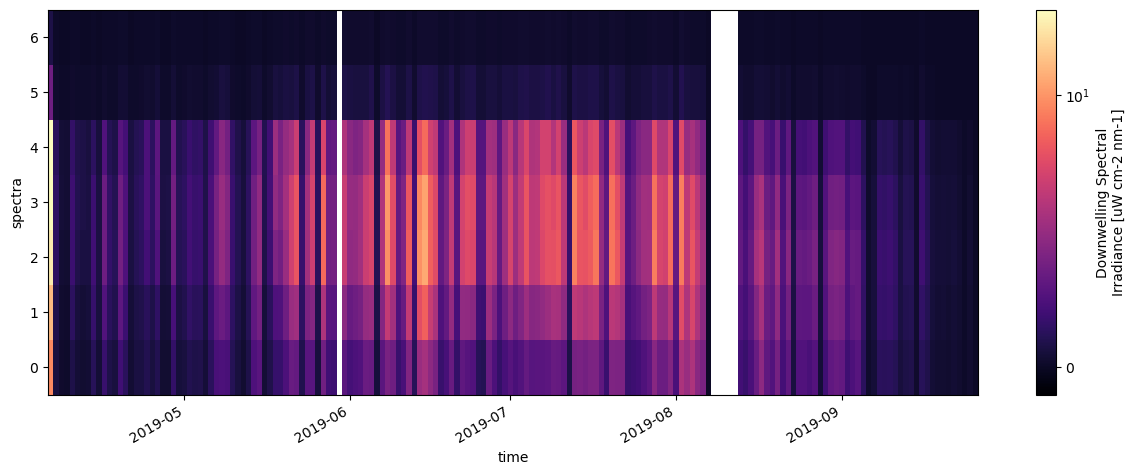

In [30]:
# pcolormesh plot with log-scale cmap except for [-1, 10] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [31]:
# Now lets try this with a 5-day median resample
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="5D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 35, spectra: 7)>
array([[6.82127204e-01, 9.39339140e-01, 1.49556243e+00, 1.66573864e+00,
        1.50775647e+00, 2.17019475e-01, 6.62599682e-02],
       [4.09351526e-01, 5.97971766e-01, 8.23282033e-01, 8.41685295e-01,
        7.24953008e-01, 1.07756459e-01, 4.46083474e-02],
       [1.11149060e+00, 1.63481436e+00, 2.06272259e+00, 1.99825457e+00,
        1.42778278e+00, 2.07900504e-01, 6.89136231e-02],
       [6.33905790e-01, 8.30168475e-01, 1.26737414e+00, 1.37036116e+00,
        1.22211412e+00, 1.81988724e-01, 5.88591173e-02],
       [4.88950510e-01, 7.05335209e-01, 1.08804481e+00, 1.18094031e+00,
        1.09429885e+00, 1.71634988e-01, 5.71144999e-02],
       [6.95715056e-01, 9.77443677e-01, 1.34453113e+00, 1.40168619e+00,
        1.25158622e+00, 1.94583331e-01, 6.10077514e-02],
       [1.77887788e+00, 2.40299210e+00, 3.25211386e+00, 3.32345650e+00,
        2.82799702e+00, 3.63398624e-01, 9.33474496e-02],
       [8.35149703e-01, 1.11870379e+00, 1.48298037e+00, 1.51192503e+00,
        1.28393037e+00, 1.92699171e-01, 5.95294177e-02],
       [1.19328147e+00, 1.70288643e+00, 2.52271664e+00, 2.78847411e+00,
        2.70395010e+00, 3.80136554e-01, 1.00454470e-01],
       [2.62830054e+00, 3.91435216e+00, 5.20132994e+00, 5.24724249e+00,
        4.42306642e+00, 5.73875815e-01, 1.45943075e-01],
...
       [2.06008457e+00, 2.58632186e+00, 3.16383481e+00, 2.98038643e+00,
        2.42941038e+00, 3.60160794e-01, 9.68550489e-02],
       [2.74753531e+00, 3.09858421e+00, 3.49182410e+00, 3.13586101e+00,
        2.39268108e+00, 3.07221372e-01, 8.25675502e-02],
       [2.20276612e+00, 2.58443371e+00, 2.88604360e+00, 2.58521177e+00,
        1.98243281e+00, 2.43159916e-01, 6.05670060e-02],
       [1.66826512e+00, 2.02154214e+00, 2.23259445e+00, 1.97611683e+00,
        1.40635816e+00, 1.69531314e-01, 4.33503864e-02],
       [2.70608963e+00, 3.34031155e+00, 3.58219552e+00, 3.11022829e+00,
        2.22732694e+00, 2.56595992e-01, 6.27982799e-02],
       [7.45937359e-01, 8.52196817e-01, 9.00792402e-01, 7.83724039e-01,
        6.10910023e-01, 8.67380087e-02, 2.31770994e-02],
       [1.05503826e+00, 1.35776975e+00, 1.46589740e+00, 1.28284831e+00,
        9.28877248e-01, 1.16683356e-01, 3.63260056e-02],
       [7.11412936e-01, 9.11214792e-01, 1.05646410e+00, 9.39103459e-01,
        7.16780233e-01, 8.74880143e-02, 2.91914385e-02],
       [3.15291575e-01, 3.98664721e-01, 4.91061523e-01, 4.47583359e-01,
        3.45641780e-01, 4.67864891e-02, 1.80901622e-02],
       [6.95465087e-03, 5.62515071e-03, 3.77377740e-03, 2.68314116e-03,
        3.17550394e-03, 3.19469816e-03, 4.37195968e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-11 ... 2019-09-23
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

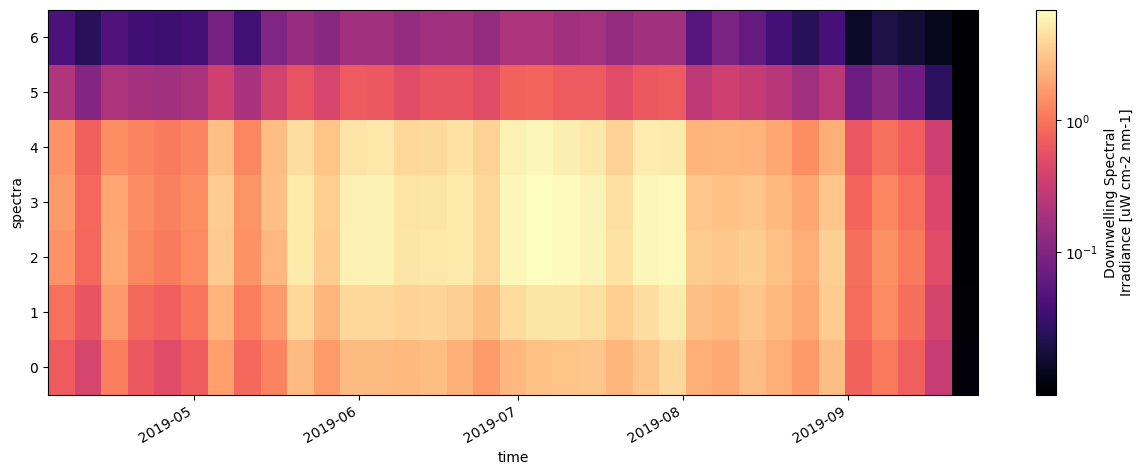

In [37]:
# 5-day median of downwelling spectral irradiance pcolormesh plot with log-scale cmap except for [0, 0.01] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=0.1))